In [2]:
import csv

def csv_graph(file):
    d = {}
    v = []
    i = 1

    with open(file, 'r') as f:
        table = csv.reader(f)

        for row in table:
            a = int(row[0])
            b = int(row[1])

            if a == i:
                v.append(b)
            else:
                d[i] = v
                i    = a
                v    = [b]

    return d

==== showing original graph ====


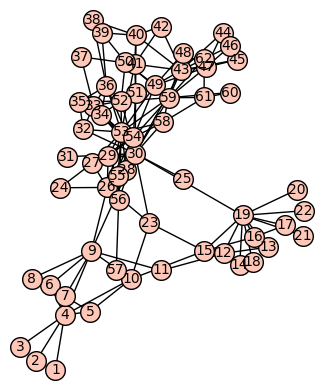

/Applications/SageMath/local/lib/python2.7/site-packages/sage/graphs/graph_plot.py:264: DeprecationWarning: Use of vertex_colors=<string> is deprecated, use vertex_color=<string> and/or vertex_colors=<dict>.
See http://trac.sagemath.org/21048 for details.
  self.set_vertices()


===== showing new cluster (yellow) + remaining nodes (white) =====


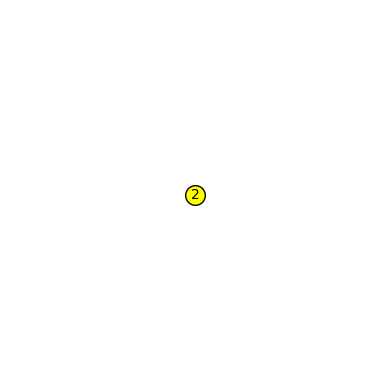

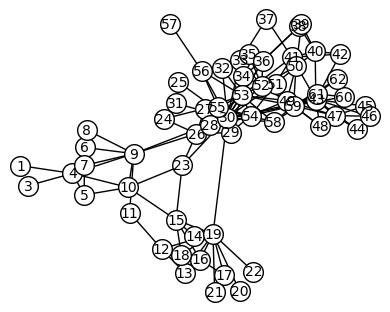

In [2]:
import numpy as np
from sage.graphs.distances_all_pairs import *
verbose = 1

fp = open("./graph.tex", 'w')   

file = "./datasets/terrorist/terrorists.csv"
d = csv_graph(file)
G = Graph(d)

print("==== showing original graph ====")
G.show()

pl = G.graphplot(vertex_colors='white')
print >> fp, 'original graph: \n \n'
print >> fp, '\\begin{figure}[h!]'
print >> fp, latex(G)
print >> fp, '\end{figure}'
print >> fp, '\clearpage \pagebreak';

current_cluster   = Graph()
current_remainder = copy(G)

V = G.num_verts()
E = G.num_edges()

current_vertex = sage.misc.prandom.choice(G.vertices())
current_cluster.add_vertex(current_vertex)
current_remainder.delete_vertex(current_vertex)

if False:

    current_cluster   = copy(G)
    current_remainder = copy(G)
    
    current_cluster.delete_vertex(1)
    current_cluster.delete_vertex(2)
    current_cluster.delete_vertex(7)
    current_cluster.delete_vertex(8)
    
    current_remainder.delete_vertex(3)
    current_remainder.delete_vertex(4)
    current_remainder.delete_vertex(5)
    current_remainder.delete_vertex(6)
    
print("===== showing new cluster (yellow) + remaining nodes (white) =====")
current_cluster.show(vertex_colors = 'yellow')
current_remainder.show(vertex_colors = 'white')

if current_cluster.num_verts() > 0:
    pl = current_cluster.graphplot(vertex_colors = 'white')
    print >> fp, 'first cluster: \n \n'
    print >> fp, '\\begin{figure}[h!]'
    print >> fp, latex(current_cluster)
    print >> fp, '\end{figure}'

pl = current_remainder.graphplot(vertex_colors = 'white')
print >> fp, 'remaining nodes: \n \n'
print >> fp, '\\begin{figure}[h!]'
print >> fp, latex(current_remainder)
print >> fp, '\end{figure}' 
print >> fp, '\clearpage \pagebreak'

moving: 4: (0.0500000000000000, 'move', -50.0000000000000, 'remain')
===== showing old cluster (yellow) + remaining nodes (white) =====


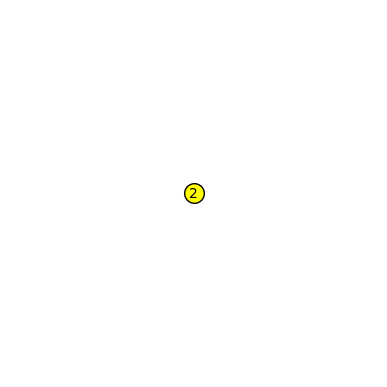

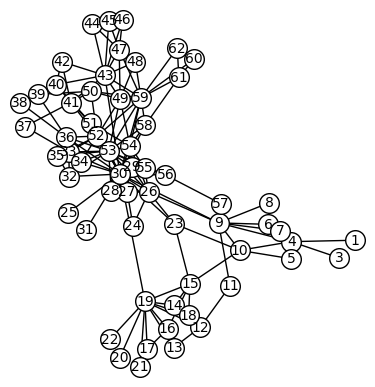

moving: 1: (-0.900000000000000, 'move', -56.0500000000000, 'remain')
===== showing old cluster (yellow) + remaining nodes (white) =====


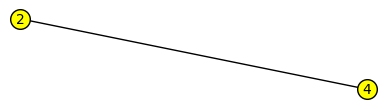

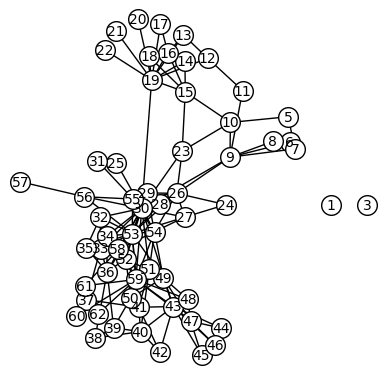

moving: 3: (-1.85000000000000, 'move', -55.1000000000000, 'remain')
===== showing old cluster (yellow) + remaining nodes (white) =====


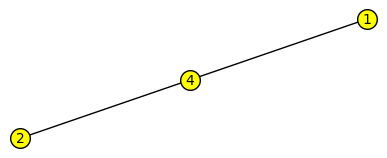

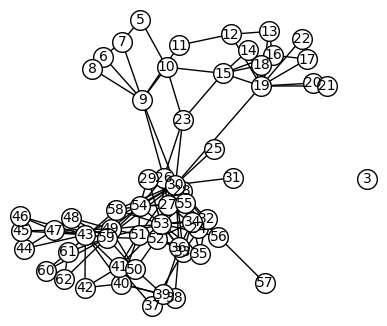

moving: 5: (-2.80000000000000, 'move', -52.1500000000000, 'remain')
===== showing old cluster (yellow) + remaining nodes (white) =====


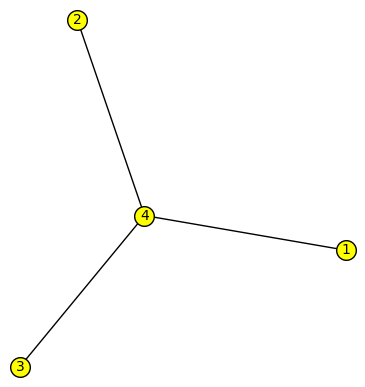

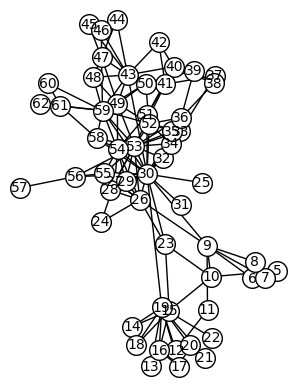

moving: 7: (-2.75000000000000, 'move', -51.2000000000000, 'remain')
===== showing old cluster (yellow) + remaining nodes (white) =====


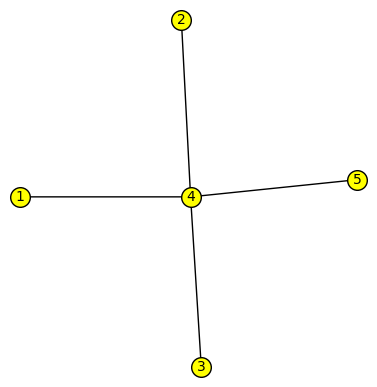

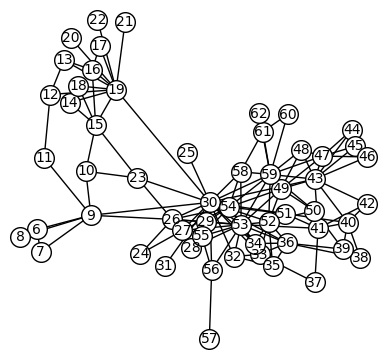

moving: 6: (-3.70000000000000, 'move', -50.2500000000000, 'remain')
===== showing old cluster (yellow) + remaining nodes (white) =====


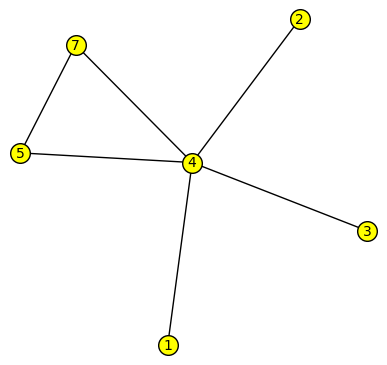

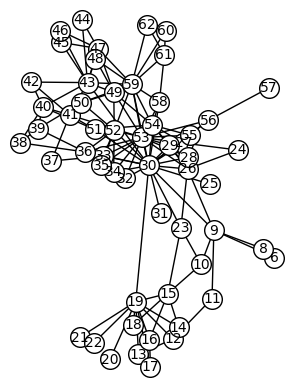

moving: 9: (-3.65000000000000, 'move', -46.3000000000000, 'remain')
===== showing old cluster (yellow) + remaining nodes (white) =====


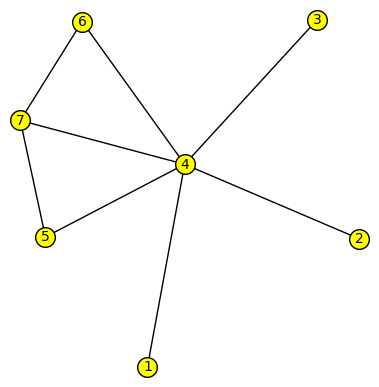

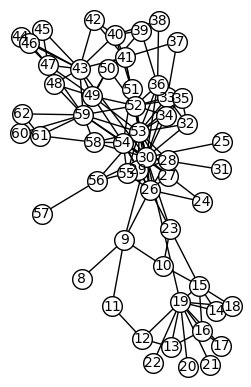

moving: 10: (-4.60000000000000, 'move', -48.3500000000000, 'remain')
===== showing old cluster (yellow) + remaining nodes (white) =====


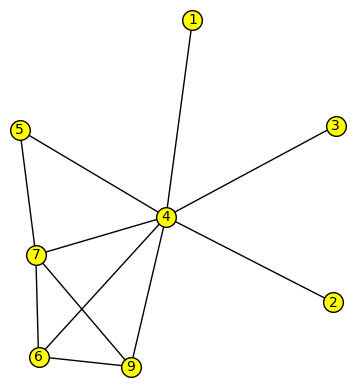

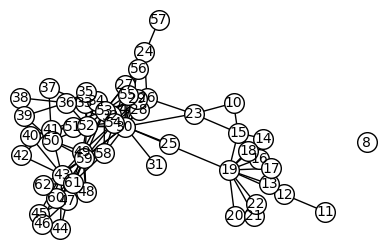

moving: 8: (-6.55000000000000, 'move', -49.4000000000000, 'remain')
===== showing old cluster (yellow) + remaining nodes (white) =====


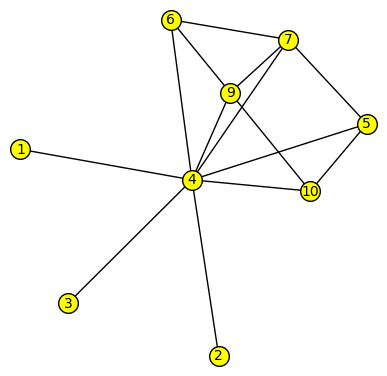

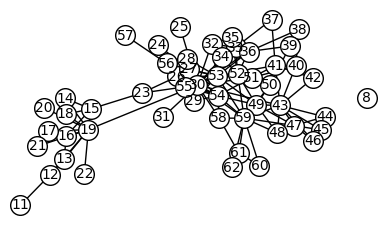

moving: 11: (-8.50000000000000, 'move', -47.4500000000000, 'remain')
===== showing old cluster (yellow) + remaining nodes (white) =====


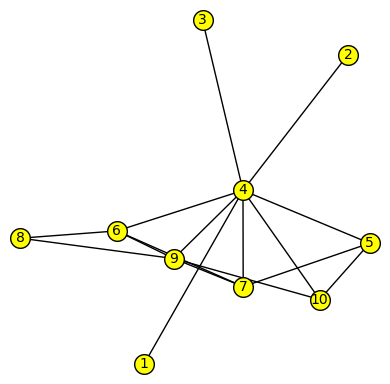

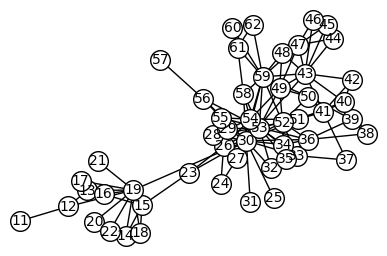

moving: 12: (-9.45000000000000, 'move', -45.5000000000000, 'remain')
===== showing old cluster (yellow) + remaining nodes (white) =====


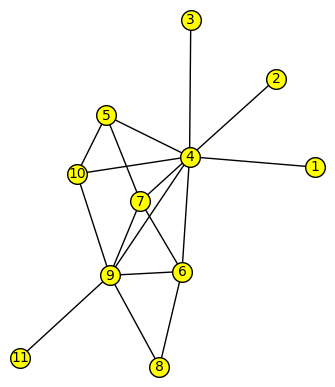

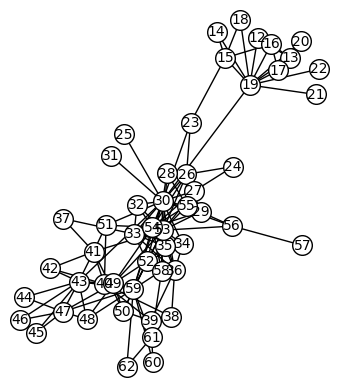

moving: 13: (-10.4000000000000, 'move', -44.5500000000000, 'remain')
===== showing old cluster (yellow) + remaining nodes (white) =====


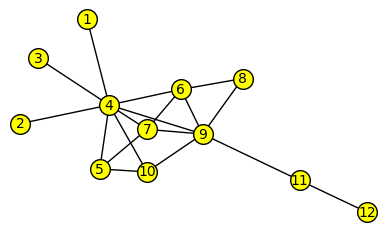

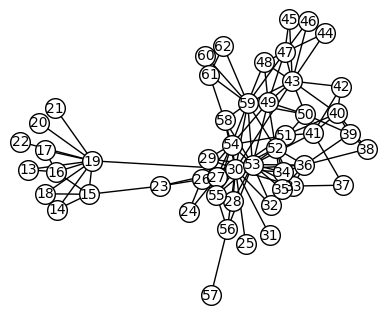

moving: 19: (-10.3500000000000, 'move', -36.6000000000000, 'remain')
===== showing old cluster (yellow) + remaining nodes (white) =====


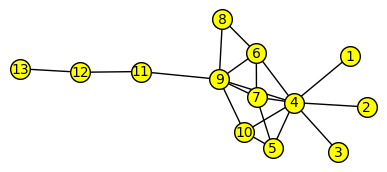

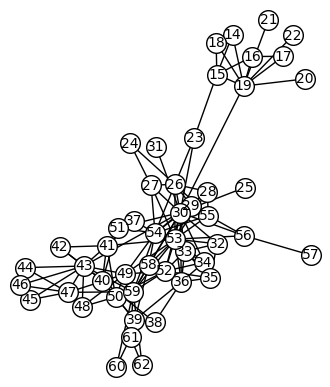

moving: 15: (-11.3000000000000, 'move', -40.6500000000000, 'remain')
===== showing old cluster (yellow) + remaining nodes (white) =====


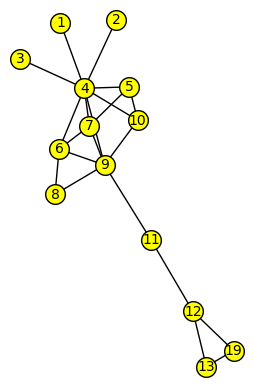

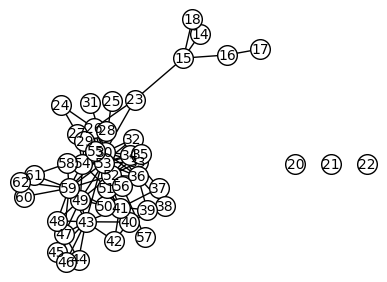

moving: 16: (-11.2500000000000, 'move', -42.7000000000000, 'remain')
===== showing old cluster (yellow) + remaining nodes (white) =====


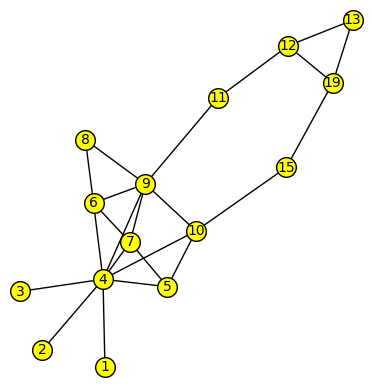

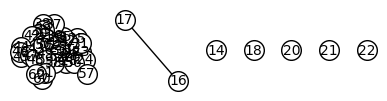

moving: 14: (-13.2000000000000, 'move', -42.7500000000000, 'remain')
===== showing old cluster (yellow) + remaining nodes (white) =====


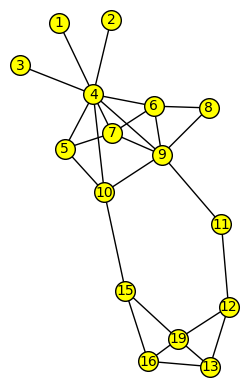

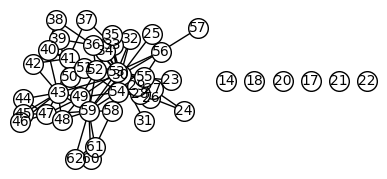

moving: 17: (-14.1500000000000, 'move', -41.8000000000000, 'remain')
===== showing old cluster (yellow) + remaining nodes (white) =====


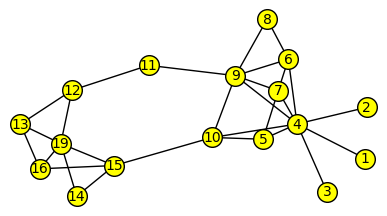

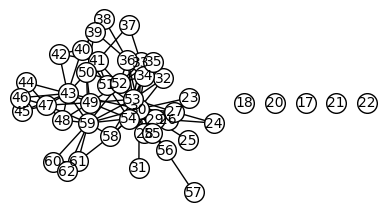

moving: 18: (-15.1000000000000, 'move', -40.8500000000000, 'remain')
===== showing old cluster (yellow) + remaining nodes (white) =====


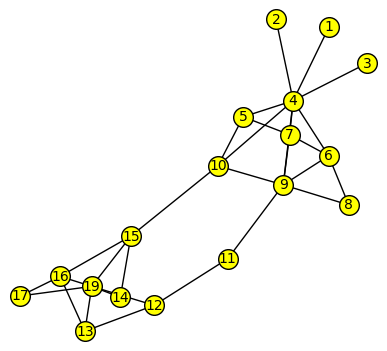

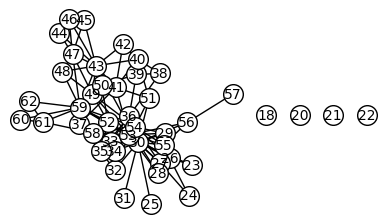

moving: 23: (-16.0500000000000, 'move', -37.9000000000000, 'remain')
===== showing old cluster (yellow) + remaining nodes (white) =====


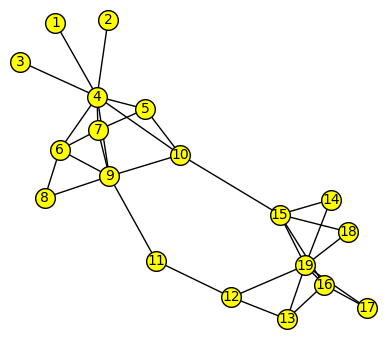

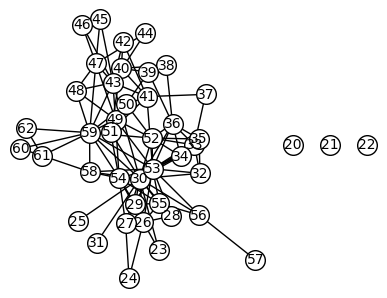

moving: 30: (-16.0000000000000, 'move', -19.9500000000000, 'remain')
===== showing old cluster (yellow) + remaining nodes (white) =====


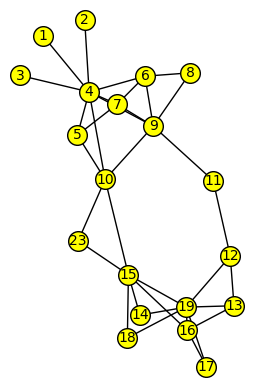

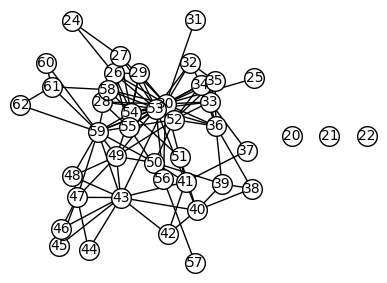

In [3]:
alpha  = 0.95

moved  = True
nmoves = 0

while moved == true and nmoves < 20:

    options      = {}
    bestresponse = {}
    moved        = False
    
    for i in G.vertices():
        
        # print(i)
        if i in current_cluster.vertices():
            other           = 'out'
            reference       = 'cluster'
            other_graph     = current_remainder
            reference_graph = current_cluster
        else:
            other           = 'cluster'
            reference       = 'out'
            other_graph     = current_cluster
            reference_graph = current_remainder 
            
        di      = reference_graph.degree(i)
        hedonic = (1 - alpha) * di - alpha * (reference_graph.num_verts() - di - 1)
        options[(i,reference)] = (di, hedonic)
        H = copy(other_graph)
        H.add_vertex(i)
        
        for j in other_graph.vertices():
            if i in G.neighbors(j): 
                H.add_edge(i,j)
                H.add_edge(j,i)

        di = H.degree(i)
        hedonic = (1 - alpha) * di - alpha * (H.num_verts() - di - 1)
        options[(i,other)] = (di, hedonic)

        
        if options[(i,other)][1] > options[(i,reference)][1]:
            bestresponse[i] = (options[(i,other)][1],    'move',
                               options[(i,reference)][1],'remain')
            
        elif options[(i,other)][1] < options[(i,reference)][1]:
            bestresponse[i] = (options[(i,reference)][1], 'remain',
                               options[(i,other)][1],     'move')
        
        elif sage.misc.prandom.choice([0,1]) == 0:
            bestresponse[i] = (options[(i,other)][1], 'move', 'tie',
                               options[(i,reference)][1], 'remain')
        
        else:
            bestresponse[i] = (options[(i,reference)][1], 'remain', 'tie',
                               options[(i,other)][1], 'move')

 
    print >> fp, '\n\n next best response vector.  node: (value, move/remain) \n\n'
        
    for key, value in sorted(bestresponse.iteritems(), key = lambda (k,v): -v[0]):
        print >> fp, "%s: %s \n\n" % (key, value);   
            
    sys.stdout.flush();   
    
    for key, value in sorted(bestresponse.iteritems(), key = lambda (k,v): -v[0]):
        if value[1] == 'move':
            print "moving: %s: %s" % (key, value)
            break
    
    if value[1] == 'move':
        
        print("===== showing old cluster (yellow) + remaining nodes (white) =====")
        current_cluster.show(vertex_colors = 'yellow')
        current_remainder.show(vertex_colors = 'white')
        
        aux_string = str(key) + ' will move'
        print >> fp, aux_string

        if key in current_cluster.vertices():
            print('edges')
            print(G.edges())
            reference_graph = current_cluster
            other_graph     = current_remainder
        else:
            reference_graph = current_remainder
            other_graph     = current_cluster
        
        vertices_of_other_graph = copy(other_graph.vertices())
        other_graph.add_vertex(key)

        for j in vertices_of_other_graph:
            if key in G.neighbors(j):
                other_graph.add_edge(key, j)
                other_graph.add_edge(j, key)
        
        reference_graph.delete_vertex(key)    
        sys.stdout.flush();  
         
        print >> fp, '==== showing new cluster + remaining nodes ===='
        pl = current_cluster.graphplot(vertex_colors = 'yellow')
        
        print >> fp, 'current cluster: \n \n'
        print >> fp, '\\begin{figure}[h!]'
        print >> fp, latex(current_cluster)
        print >> fp, '\end{figure}'

        pl = current_remainder.graphplot(vertex_colors = 'white')
        print >> fp, 'current remainder: \n \n'
        print >> fp, '\\begin{figure}[h!]'
        print >> fp, latex(current_remainder)
        print >> fp, '\end{figure}'
       
        current_cluster.plot(vertex_colors = 'yellow').save('/tmp/foo.png')

        import matplotlib.pyplot
        img = matplotlib.image.imread('/tmp/foo.png')
        matrix_plot(img)
        
        current_remainder.plot(vertex_colors = 'white').save('/tmp/foo.png')
        sys.stdout.flush();
        print >> fp, '\clearpage \pagebreak'
         
        moved   = True
        nmoves += 1
        
fp.close()